# **Parallel computing with CUDA & Python**

## Sorting arrays 

The aim of this tutorial is to understand the differences in performance between sequential and parallel programming. For this we will be performing two operations: Array sorting and image convolution on CPU and GPU using SciPy and CuPy respectively.

**Note: Before coding anything, make sure to change your runtime type from None to GPU or CPU, then restart the runtime and install CuPy by running the following command:**

In [ ]:
!pip install cupy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
  Created wheel for cupy: filename=cupy-11.1.0-cp37-cp37m-linux_x86_64.whl size=97634352 sha256=22a1a03b0e1078d8e669f62435039072e3047bb65577f5ae15244a3cf93dff29
  Stored in directory: /root/.cache/pip/wheels/02/56/0f/aee1cce30008d2883e79991d1ed46ef3638acf49bd11ef0f3f
Successfully built cupy


In [2]:
import numpy as np
np.random.seed(42)  #This is to get the same random elements after re-running the cell 
size = 8192 * 8192  #dimensions of the image we will be creating
array = np.random.random(size).astype(np.float32) #create a numpy array of size 'size' and filling it with random elements of type float
print(array)

[0.37454012 0.9507143  0.7319939  ... 0.31690636 0.27552673 0.97867715]


In [ ]:
%timeit -n 1 -r 1 result = np.sort(array)

7.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now let's perform the same sorting, but this time on a GPU. We will be using the sort() function from CuPy

In [3]:
import cupy as cp
array_gpu = cp.asarray(array)
%timeit -n 7 -r 1 result_gpu = cp.sort(array_gpu)

152 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 7 loops each)


In [ ]:
speedup = 7.84 / 0.0366
print(speedup)

214.20765027322403


We can therefore say that by only using the GPU with CuPy to sort an array of size 8192 * 8192 we achieved a performance improvement of 214 times.

**Note: If we reduce the size of the array, say to 2048*2048, there won't be a considerable change in the performance. So, the speedup won't be that big (5.5 in this case)**

## Convolution in Python

In [4]:
import numpy as np

# Construct an image with repeated delta functions
deltas = np.zeros((4096, 4096))
deltas[8::16,8::16] = 1

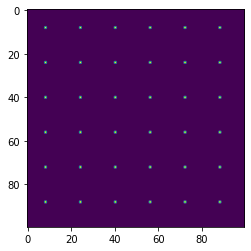

In [5]:
import pylab as pyl
# Necessary command to render a matplotlib image in a Jupyter notebook.
%matplotlib inline

# Display a part of the image (Top Left)
pyl.imshow(deltas[0:100, 0:100])
pyl.show()

### Convolution on CPU 

We will be applying the BICUBIC Inerpolation method on our image. It is known for its ideal combination of processing time and output quality. That's why it's often used in image editing programs like Adobe Photoshop.

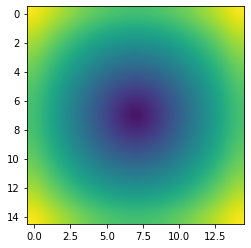

In [6]:
from PIL.Image import NEAREST
from scipy.signal.windows import gaussian
x, y = np.meshgrid(np.linspace(-2, 2, 15), np.linspace(-2, 2, 15))
dst = np.sqrt(x*x + y*y)
sigma = 1
muu = 0.000
#gauss = np.exp(-((dst-muu)**2/(2.0 * sigma**2)))
pyl.imshow(dst,interpolation='bicubic')
pyl.show()

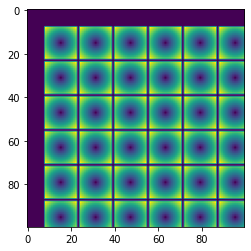

9.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
from scipy.signal import convolve2d as convolve2d_cpu

convolved_image_using_CPU = convolve2d_cpu(deltas, dst)
pyl.imshow(convolved_image_using_CPU[0:100, 0:100])
pyl.show()
%timeit -n 1 -r 1 convolve2d_cpu(deltas, dst)

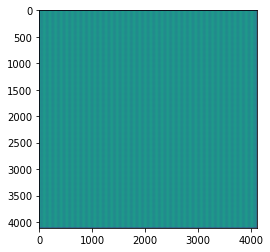

In [ ]:
#Fully displayed image
pyl.imshow(convolved_image_using_CPU)
pyl.show()

### Convolution on GPU

In [8]:
import cupy as cp

deltas_gpu = cp.asarray(deltas)
dst_gpu = cp.asarray(dst)

In [9]:
from cupyx.scipy.signal import convolve2d as convolve2d_gpu

convolved_image_using_GPU = convolve2d_gpu(deltas_gpu, dst_gpu)
%timeit -n 7 -r 1 convolved_image_using_GPU = convolve2d_gpu(deltas_gpu, dst_gpu)

118 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 7 loops each)


In [16]:
#Speedup
speedup_conv = 9.98 / 0.000118
speedup_conv

84576.27118644069

That's impressive!! You see there is a far cry between the speedup we got when performing a normal computation and the one we got in image redering! That's the where the power of GPUs comes into play!

## Performing NumPy routines on the GPU

**Transfer function**

In [20]:
def transfer_compute_transferback():
    deltas_gpu = cp.asarray(deltas)
    dst_gpu = cp.asarray(dst)
    convolved_image_using_GPU = convolve2d_gpu(deltas_gpu, dst_gpu)
    convolved_image_using_GPU_copied_to_host = cp.asnumpy(convolved_image_using_GPU)

In [17]:
deltas_1d = deltas.ravel()
dst_1d = dst.diagonal()
%timeit -n 1 -r 1 np.convolve(deltas_1d, dst_1d)

381 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
deltas_1d_gpu = cp.asarray(deltas_1d)
dst_1d_gpu = cp.asarray(dst_1d)
%timeit -n 7 -r 1 np.convolve(deltas_1d_gpu, dst_1d_gpu)

1.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 7 loops each)


In [19]:
spdup = 382 / 1.43
spdup

267.13286713286715

# **Creating a GPU Kernel**

### Summing two vectors 

In [21]:
def vector_add(A, B, C, size):
    for item in range(0, size):
        C[item] = A[item] + B[item]
    
    return C

### Running Code on the GPU with CuPy

In [22]:
import cupy

# size of the vectors
size = 1024

# allocating and populating the vectors
a_gpu = cupy.random.rand(size, dtype=cupy.float32)
b_gpu = cupy.random.rand(size, dtype=cupy.float32)
c_gpu = cupy.zeros(size, dtype=cupy.float32)

# CUDA vector_add
vector_add_cuda_code = r'''
extern "C"
__global__ void vector_add(const float * A, const float * B, float * C, const int size)
{
    int item = threadIdx.x;
    C[item] = A[item] + B[item];
}
'''
vector_add_gpu = cupy.RawKernel(vector_add_cuda_code, "vector_add")

vector_add_gpu((1, 1, 1), (size, 1, 1), (a_gpu, b_gpu, c_gpu, size))

In [23]:
import numpy

a_cpu = cupy.asnumpy(a_gpu)
b_cpu = cupy.asnumpy(b_gpu)
c_cpu = numpy.zeros(size, dtype=numpy.float32)

vector_add(a_cpu, b_cpu, c_cpu, size)

# test
if numpy.allclose(c_cpu, c_gpu):
    print("Correct results!")

Correct results!
